In [29]:
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.feature_selection import f_classif

In [21]:
#
# 1. DATA LOAD
# 
# Kaggle에서 제공하는 [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/data)데이터를 활용
# BNP Paribas Cardif 청구관리 데이터 셋으로 고객의 클레임 여부를 판단하는 데이터셋의 Subset
DATA_PATH = "c:\\Users\\WAI\\OneDrive\\03.WORKSPACE\\00.DATA\\"
df = pandas.read_csv(DATA_PATH + "BookExample.csv")
print(df.shape) # (20000, 33)

# 연속형 변수만 추출
n_obj_cols = []
for col, type in zip(df.dtypes.index, df.dtypes.values):
    if type != ("object"):
        n_obj_cols.append(col)

n_obj_df = df[n_obj_cols]
print(n_obj_df.shape)


# 학습, 검증 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(n_obj_df.drop(labels=["ID","target"], axis=1),
                                                    n_obj_df["target"],
                                                    test_size=0.2,
                                                    random_state=42)

print("Train Shape : {0}, Test Shape : {1}".format(train_x.shape, test_x.shape))

(20000, 33)
(20000, 28)
Train Shape : (16000, 26), Test Shape : (4000, 26)


In [3]:
# 1. 상수항 제거를 위한 분산 임계치 사용
# 상수변수를 제거하기 위해서 VarianceTreshold를 사용할 것입니다.
# 표본 변화에 따른 데이터 값의 변화 즉, 분산이 기준치보다 낮은 특징 데이터를 제거하는 방법입니다.
# 상수항의 경우 동일한 값으로 구성되어 있어 데이터의 분산이 0인 특징을 가지고 있어
# 모델에 영향력이 없습니다. 학습 시간 및 시스템 자원의 효율성을 위해 상수항 이나 Quasi-Constants와 
# 같은 데이터 항은 제거해주어야합니다
# Quasi-Constants : 데이터의 전부는 아니지만 99%가 동일한 값으로 구성되어 있는 특성
# 분산임계치를 사용하여 손쉽게 제거할 수 있습니다.


# 분산이 0.1 미만인 Feature를 찾아 제거해보도록 하겠습니다.

# 상수항으로 구성된 Feature를 제거

constant_filter = VarianceThreshold(0.1)
constant_filter.fit(train_x)
print(len(train_x.columns[constant_filter.get_support()]))

constant_columns = [column for column in train_x.columns
                    if column not in train_x.columns[constant_filter.get_support()]]


print("Removed Columns count : {} ".format(len(constant_columns)))
print(constant_columns)


# VarianceTreshold로 선택된 Feature들로 train, test Feature 재구성
train_x_sel = constant_filter.transform(train_x)
test_x_sel = constant_filter.transform(test_x)
print("Train Shape after adjusting VarianceTreshold : {} ".format(train_x_sel.shape))
# 처음 Train Data의 Feature는 총 26 였는데, 1개 Feature가 감소한것을 확인할 수 있습니다.

25
Removed Columns count : 1 
['v19']
Train Shape after adjusting VarianceTreshold : (16000, 25) 


In [23]:
# 2. 상관계수(Correlation)
# 상관계수를 확인하여, 특성간 상관성이 높은 특성을 제거할 수 있습니다.
correlated_features = set()
corr_df = df.set_index(["ID","target"])
correlation_matrix = corr_df.corr()

# 특성들간 상관계수가 0.8 이상인 특성을 제거해보도록 하겠습니다. 
# Feature들 간의 상관계수가 0.8 이상인 Feature 제거

for i in range(len(correlation_matrix.columns)):
    #print(i)
    #print("range :  {} ".format(range(i)))
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j] > 0.8):
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features))            
print(correlated_features)

train_x_sel = train_x.drop(labels=correlated_features, axis=1)
test_x_sel = test_x.drop(labels=correlated_features, axis=1)

print("Train Shape after adjusting VarianceTreshold : {} ".format(train_x_sel.shape))

# 총 26개의 특성중 18개의 특성이 서로 상관성이 높아 제거되고, 8개의 특성이 선택된것을 확인할 수 있습니다.


18
{'v5', 'v12', 'v19', 'v7', 'v16', 'v17', 'v11', 'v13', 'v15', 'v26', 'v29', 'v25', 'v28', 'v20', 'v4', 'v9', 'v27', 'v6'}
Train Shape after adjusting VarianceTreshold : (16000, 8) 


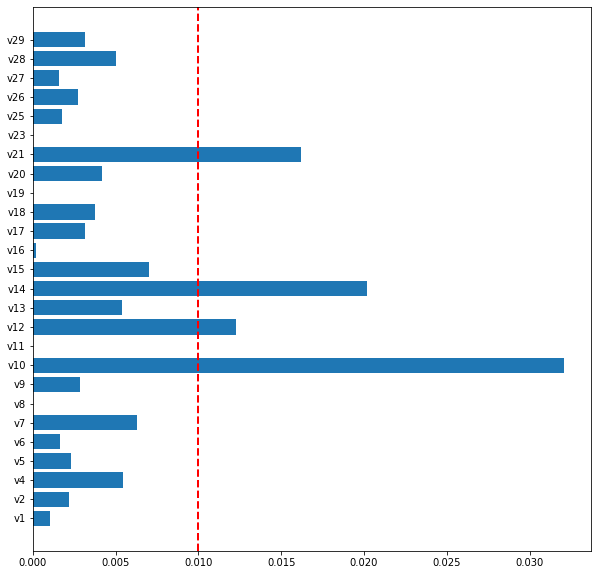

Index(['v10', 'v12', 'v14', 'v21'], dtype='object')


In [27]:
# 3. Mutual Information
# 일반적으로 특성을 관찰한후 종속변수의 불확실성 감소를 측정하는 지표입니다.
# 특성과 종속변수간의 단변량 의존성을 측정하게 되고, 값이 작을 수록 특성은 종속변수에 영향력이 낮다고
# 판단할 수 있습니다. mutual_inf_ 메소드를 사용하기 위해 모든 특성값에 결측값 없어야 합니다.
# Class의 분포가 균일 하지 않다면 정보값이 매우 작아질 수 있어 rescaling을 고려해야하는 주의점이 있습니다.

# 정보값의 임계치
threshold = 0.01

high_score_feature = []
feature_scores = mutual_info_classif(train_x.fillna(0), train_y, random_state=41)


fig, axes = plt.subplots(1,1, figsize = (10,10))
pos = numpy.arange(len(feature_scores))
plt.barh(pos, feature_scores)
plt.yticks(pos , train_x.columns)

plt.axvline(x=threshold, color='red', linestyle='--', linewidth = 2)
plt.show()


for score, f_name in zip(feature_scores, train_x.columns):
    # print(f_name, score)
    if score > threshold:
        high_score_feature.append(f_name)

train_x_sel = train_x[high_score_feature]
print(train_x_sel.columns)

# 각특성의 mutual information 값이 전체적으로 낮게 구성되어 있고, 임계치를 넘는 값을 가지는
# 4개의 특성이 선택된것을 확인할 수 있습니다. 

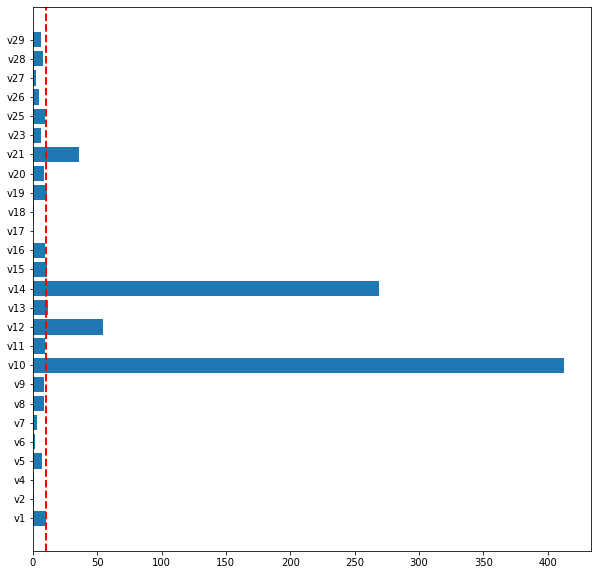

Index(['v1', 'v19', 'v15', 'v13', 'v21', 'v12', 'v14', 'v10'], dtype='object')


In [32]:
# 4. ANOVA F-test
# 특성에 대하여 분산 분석을 수행한 F-test 결과를 사용하는 방법입니다.
# 선형 의존성만 고려한 방법이며 일원 분산 분석(독립변수 연속형, 종속변수 이산/범주형)을 수행합니다.
# Feature selection 방법중에 잘 사용되는 방법은 아닙니다.


feature_scores = f_classif(train_x.fillna(0), train_y)[0]
high_score_feature = []

threshold = 10
# visualizaion

fig, axes = plt.subplots(1,1, figsize = (10,10))
pos = numpy.arange(len(feature_scores))
plt.barh(pos, feature_scores)
plt.yticks(pos , train_x.columns)

plt.axvline(x=threshold, color='red', linestyle='--', linewidth = 2)
plt.show()

for score, f_name in sorted(zip(feature_scores, train_x.columns)):
    #print(f_name, " : ", score)
    if(score > threshold):
        high_score_feature.append(f_name)

train_x_sel = train_x[high_score_feature]
print(train_x_sel.columns)